# Answering Business Questions using SQL

The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables.



In [1]:
import pandas as pd
import sqlite3
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)
    
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(q)
        
def show_tables():
    q='SELECT name,type FROM sqlite_master WHERE type IN ("table","view");'
    return run_query(q)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name	     |Genre
|--------------------|---------
|Regal	             |Hip-Hop
|Red Tone	         |Punk
|Meteor and the Girls|Pop
|Slim Jim Bites	     |Blues

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [4]:
query="""
SELECT g.name genre,
       COUNT(t.genre_id) number_of_tracks,
       100*CAST(COUNT(t.genre_id) as float)/CAST((SELECT COUNT(track_id) FROM track) as float) percentage
FROM track t 
INNER JOIN genre g ON g.genre_id=t.genre_id
GROUP BY g.name
ORDER BY 2 DESC"""
genres=run_query(query)
genres

,genre,number_of_tracks,percentage
0,Rock,1297,37.025407
1,Latin,579,16.528690
2,Metal,374,10.676563
3,Alternative & Punk,332,9.477591
4,Jazz,130,3.711105
5,TV Shows,93,2.654867
6,Blues,81,2.312304
7,Classical,74,2.112475
8,Drama,64,1.827005
9,R&B/Soul,61,1.741365


Text(0, 0.5, '%')

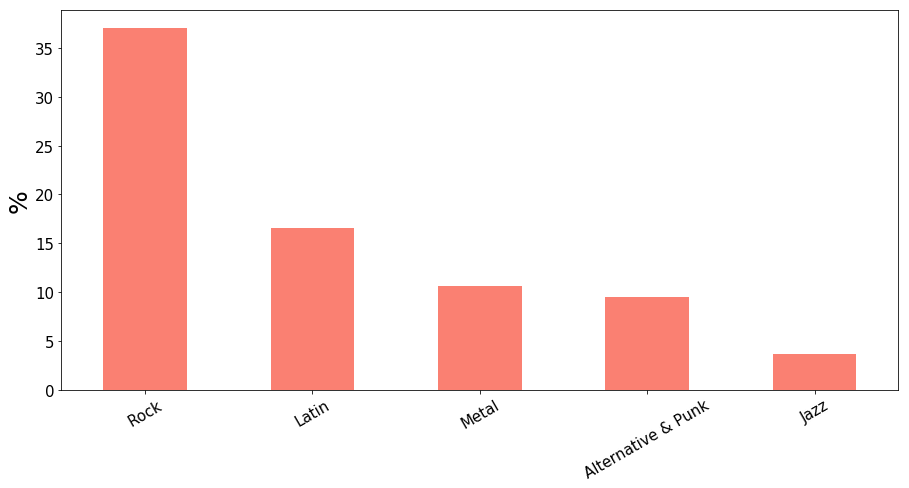

In [5]:
genres[:5].plot(kind='bar',x='genre',y='percentage',legend=False,color='salmon',figsize=(15,7),fontsize=15,rot=30)
plt.xlabel("")
plt.ylabel("%",size=25)

As we can see, Rock is the predominent genre for our store. Latin, Metal, Alternative & Punk and Jazz are also popular among our clients. We will therefore choose the following three artists:
* Reg Tone: Punk is on our popular list
* Slim Jim Bites: Although we do not have Blues on our top 5 list, it still ranks 7th on the popularity list. It is also very likely that people who listen to Rock or Jazz appreciate Blues music.
* Meteor and the Girls: By ranking, Pop beats Hip-Hop

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. WE have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

However, the sales numbers of the employees might depend on other factors.
Let us take a closer look at the `employee` table.

In [6]:
query="SELECT * FROM employee LIMIT 1"
run_query(query)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,None,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com


The most obvious column to look into is `hire_date`, since if an employee has  been working at the shop for a long time he most probably has a higher sales number than a new employee.

In [7]:
query="""
SELECT e.first_name||" "||e.last_name employee_name,
       SUM(i.total) total_sales,
       e.title,
       e.hire_date
FROM employee e
LEFT JOIN customer c ON c.support_rep_id=e.employee_id
LEFT JOIN invoice i ON i.customer_id=c.customer_id
GROUP BY e.employee_id
ORDER BY 2 DESC"""

sales_performance=run_query(query)
sales_performance

,employee_name,total_sales,title,hire_date
0,Jane Peacock,1731.51,Sales Support Agent,2017-04-01 00:00:00
1,Margaret Park,1584.00,Sales Support Agent,2017-05-03 00:00:00
2,Steve Johnson,1393.92,Sales Support Agent,2017-10-17 00:00:00
3,Andrew Adams,NaN,General Manager,2016-08-14 00:00:00
4,Nancy Edwards,NaN,Sales Manager,2016-05-01 00:00:00
5,Michael Mitchell,NaN,IT Manager,2016-10-17 00:00:00
6,Robert King,NaN,IT Staff,2017-01-02 00:00:00
7,Laura Callahan,NaN,IT Staff,2017-03-04 00:00:00


As expected, only the sales support agents have a non-null `total_sales` number. At first glance we might think that Jane Peacock is performing the best, but we notice that she was hired before the other salesmen. The lowest ranking in `total_sales` Steve Johnson, also happens to be hired last. This could be a possible explanation for the sales gap.

Another way to measure the performance of each sales agent is to compute the daily average dollar amount of sales assigned to him.
We will have to divide each employee's `total_sales` by the number of days since he or she was hired. We will take the last invoice to be the last update of the database.

In [8]:
run_query("SELECT invoice_date FROM invoice ORDER BY invoice_date DESC LIMIT 5")

,invoice_date
0,2020-12-30 00:00:00
1,2020-12-29 00:00:00
2,2020-12-27 00:00:00
3,2020-12-27 00:00:00
4,2020-12-21 00:00:00


This is not an error, this is a fictional shop.
The last update was made around 2020-12-30. Now let us clean the table.

In [9]:
sales_performance=sales_performance[['employee_name','total_sales','hire_date']]
sales_performance=sales_performance[:3]
sales_performance

,employee_name,total_sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


In [10]:
sales_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
employee_name    3 non-null object
total_sales      3 non-null float64
hire_date        3 non-null object
dtypes: float64(1), object(2)
memory usage: 152.0+ bytes


In [11]:
def strp(str_):
    str_=str_[:10]   ##keeping the YYYY-MM-DD only
    return dt.datetime.strptime(str_,"%Y-%m-%d")

sales_performance['hire_date']=sales_performance['hire_date'].apply(strp)

# computing the difference 
sales_performance['work_days']=sales_performance['hire_date'].apply(lambda x: dt.datetime(2020,12,30)-x)

# converting to int 
sales_performance['work_days']=sales_performance['work_days'].dt.days

sales_performance['dollar_per_day']=sales_performance['total_sales']/sales_performance['work_days']

In [12]:
sales_performance[['employee_name','dollar_per_day']].sort_values('dollar_per_day',ascending=False)

,employee_name,dollar_per_day
0,Jane Peacock,1.264799
2,Steve Johnson,1.191385
1,Margaret Park,1.184742


We can see that Jane Peacock still holds the first place, while Steve Johnson is now second as per the daily average amount of sales. However, the difference between the employees does not exeed 0.07$ a day which is insignificant. Therefore we cannot conclude anything about their performance.

## Analyzing Sales by Country

Our next task is to analyze the sales data for customers from each different country. We have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, we have been directed to calculate data, for each country, on the:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

In [13]:
run_command('DROP VIEW t1') ## In case we need to restart the Kernel

In [14]:
c="""
CREATE VIEW t1 AS
        SELECT c.country,
               COUNT(DISTINCT(c.customer_id)) customers,
               SUM(i.total) sales,
               COUNT(i.invoice_id) orders
        FROM customer c
        LEFT JOIN invoice i ON i.customer_id=c.customer_id
        GROUP BY c.country;
        """
run_command(c)


In [15]:
run_query('SELECT * FROM t1')

,country,customers,sales,orders
0,Argentina,1,39.60,5
1,Australia,1,81.18,10
2,Austria,1,69.30,9
3,Belgium,1,60.39,7
4,Brazil,5,427.68,61
5,Canada,8,535.59,76
6,Chile,1,97.02,13
7,Czech Republic,2,273.24,30
8,Denmark,1,37.62,10
9,Finland,1,79.20,11


In [16]:
q="""
WITH t2 AS(
        SELECT * FROM (SELECT * FROM t1 WHERE customers!=1
                   UNION
                   SELECT country,
                           SUM(customers) customers, 
                           SUM(sales) sales,
                           SUM(orders) orders
                   FROM t1 WHERE customers=1 GROUP BY customers
                   ORDER BY sales DESC)
                   )

SELECT country,
       customers,
       sales,
       sales/customers sales_per_customer,
       sales/orders avg_order_value
FROM (
        SELECT * , 
                CASE 
                    WHEN country='Sweden' THEN 1
                    ELSE 0 
                END AS sort
        FROM t2
        )
ORDER BY sort ASC
                    
"""

country_sales=run_query(q)
country_sales

,country,customers,sales,sales_per_customer,avg_order_value
0,Argentina,15,1094.94,72.996000,7.448571
1,USA,13,1040.49,80.037692,7.942672
2,Canada,8,535.59,66.948750,7.047237
3,Brazil,5,427.68,85.536000,7.011148
4,France,5,389.07,77.814000,7.781400
5,Germany,4,334.62,83.655000,8.161463
6,Czech Republic,2,273.24,136.620000,9.108000
7,United Kingdom,3,245.52,81.840000,8.768571
8,Portugal,2,185.13,92.565000,6.383793
9,India,2,183.15,91.575000,8.721429


Sweden actually represents "Others" so we will modify that in the dataframe.

In [17]:
country_sales['country'][9]='Others'
country_sales

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,country,customers,sales,sales_per_customer,avg_order_value
0,Argentina,15,1094.94,72.996000,7.448571
1,USA,13,1040.49,80.037692,7.942672
2,Canada,8,535.59,66.948750,7.047237
3,Brazil,5,427.68,85.536000,7.011148
4,France,5,389.07,77.814000,7.781400
5,Germany,4,334.62,83.655000,8.161463
6,Czech Republic,2,273.24,136.620000,9.108000
7,United Kingdom,3,245.52,81.840000,8.768571
8,Portugal,2,185.13,92.565000,6.383793
9,Others,2,183.15,91.575000,8.721429


Text(0.5, 1.0, 'Proportion of customers by country')

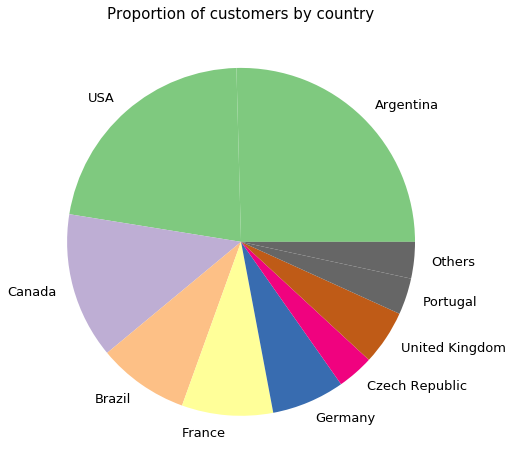

In [18]:
country_sales['customers'].plot.pie(labels=country_sales['country'],fontsize=13,colormap='Accent',figsize=(8,8))
plt.ylabel('')
plt.title('Proportion of customers by country',fontsize=15)

We can see that most of the store's customers are from USA, Canada, Brazil, France and Germany. They represent more than 50% of our clients.

Text(0.5, 1.0, 'Sales by country')

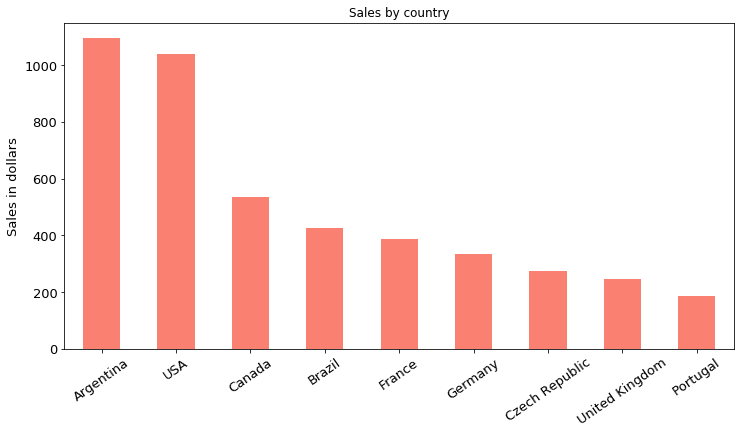

In [19]:
country_sales[:-1].plot(kind='bar',x='country',y='sales',fontsize=13,color='salmon',rot=35,legend=False,figsize=(12,6))
plt.ylabel('Sales in dollars',fontsize=13)
plt.xlabel('')
plt.title('Sales by country')


Unsurprisingly, these five countries also rank at the top of the sales list which might indicate a correlation between the number of customers and the sales. The USA holds the first position with more than \$1,000 of sales, followed by Canada with around $500 in sales. 

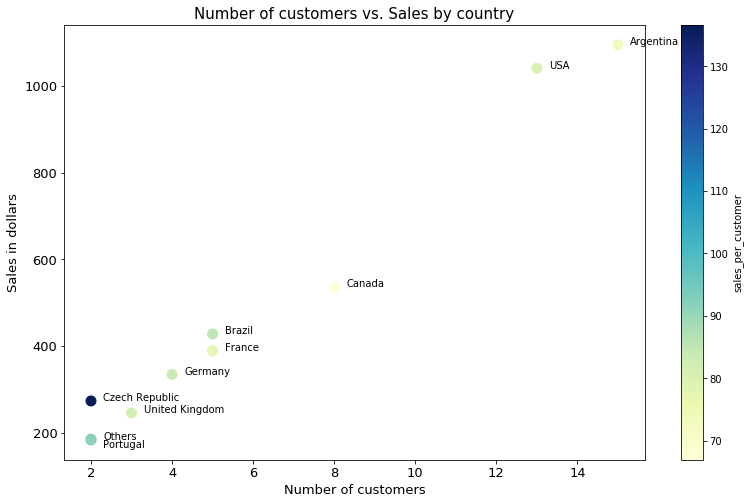

In [20]:
fig,ax=plt.subplots()
country_sales.plot(kind='scatter',x='customers',y='sales',c='sales_per_customer',fontsize=13,s=100,colormap='YlGnBu',figsize=(13,8),ax=ax)
plt.ylabel('Sales in dollars',fontsize=13)
plt.xlabel('Number of customers',fontsize=13)
plt.title('Number of customers vs. Sales by country',fontsize=15)

for i in range(0,10) :
    if i==8:
         ax.annotate(country_sales['country'][i], (country_sales['customers'][i]+0.3, country_sales['sales'][i]-20))
    else:    
        ax.annotate(country_sales['country'][i], (country_sales['customers'][i]+0.3, country_sales['sales'][i]))
    


Indeed, there is a linear relationship between the Number of customers from a certain country and the sales amount from this country. This is most probably a causation, since 10 customers are more likely to buy more than 5 customers. If the store succeeds in winning customers over from a certain country, the sales from this country will inevitably rise. 

On the other hand, we notice that the Czech Republic and India have the highest sales amount per customer. This could indicate a customer base that is willing to pay more money for a purchase from the store.  

Text(0.5, 1.0, 'Average order value by country')

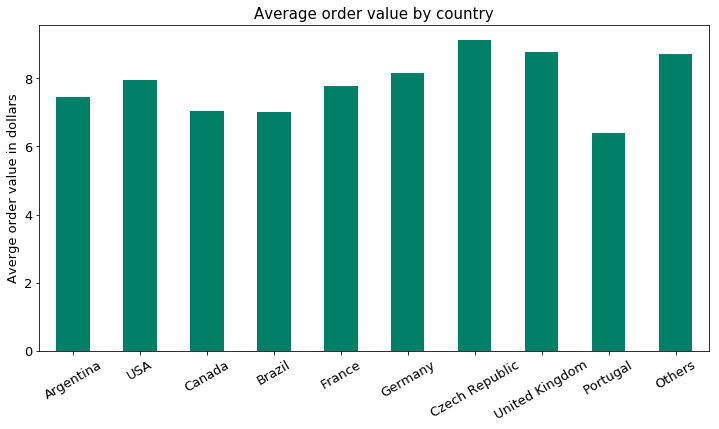

In [21]:
country_sales.plot(kind='bar',x='country',y='avg_order_value',fontsize=13,figsize=(12,6),colormap='summer',legend=False,rot=30)
plt.xlabel('')
plt.ylabel('Averge order value in dollars',fontsize=13)
plt.title('Average order value by country', fontsize=15)

The Czech Republic, the United Kingdom and India have a high average order value, which solidifies our previous observation.

**CONCLUSION: ** We would recommend that the marketing team focuses on the Czech Republic and India. A good marketing campaign could significantly increase the number of customers from these two countries. The United Kingdom could be an easier target since English is the first language of both the UK and the USA (where the store is based), which would not necessarily require expanding their music genre.

## Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [22]:
run_command('DROP VIEW t3') # in case we restart the kernel

In [23]:
c="""
CREATE VIEW t3 AS
        SELECT *
        FROM invoice i
        INNER JOIN invoice_line il ON i.invoice_id=il.invoice_id
        INNER JOIN track t ON t.track_id=il.track_id 
"""

run_command(c)

In [24]:
q="""
WITH 
    t4 AS(
        SELECT invoice_id, album_id FROM t3 GROUP BY invoice_id
    ),
    t5 AS(              
        SELECT t3.* FROM t3
        INNER JOIN t4 ON t4.invoice_id=t3.invoice_id
        WHERE t3.album_id=t4.album_id
    ),
    t6 AS(
        SELECT * FROM t3
        EXCEPT
        SELECT * FROM t5
    ),
    t7 AS( 
        SELECT invoice_id FROM t6 GROUP BY invoice_id
    )
   
SELECT i.*,
       CASE 
           WHEN t7.invoice_id IS NULL THEN 1
           ELSE 0
        END album
FROM invoice i
LEFT JOIN t7 ON t7.invoice_id=i.invoice_id

"""

invoice_is_album=run_query(q)
invoice_is_album.head()

,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total,album
0,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,1
1,2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.90,0
2,3,40,2017-01-05 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98,0
3,4,18,2017-01-06 00:00:00,627 Broadway,New York,NY,USA,10012-2612,7.92,0
4,5,27,2017-01-07 00:00:00,1033 N Park Ave,Tucson,AZ,USA,85719,16.83,1


In [25]:
invoice_is_album['album'].value_counts()

0    443
1    171
Name: album, dtype: int64

In [26]:
100*invoice_is_album['album'].value_counts()/invoice_is_album.shape[0]

0    72.149837
1    27.850163
Name: album, dtype: float64

As we can see, 72% of the invoices are not album purchases. If people are not buying the full album it means that they are not interested in all the songs, 